In [ ]:
# installs

# colab
# ! pip install scikit-plot

# local/server
# pip install scikit-plot

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

import scikitplot as skplot

In [ ]:
# COLAB - auth big query

# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated')

In [2]:
# get the data
SQL = "SELECT * from `questrom.datasets.spotify_2018`"
PROJECT = "ba820-fall21"


spotify = pd.read_gbq(SQL, PROJECT)

In [3]:
# the shape
spotify.shape

(100, 16)

In [4]:
# quick review
spotify.head(3)

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7m9OqQk4RVRkw9JJdeAw9,Jocelyn Flores,XXXTENTACION,0.872,0.391,0.0,-9.144,0.0,0.2420,0.4690,0.000004,0.297,0.437,134.021,119133.0,4.0
1,6jA8JUuPCGYjFcgw0AoM5,Me Niego,Reik,0.777,0.779,0.0,-4.449,0.0,0.0972,0.0543,0.000000,0.636,0.768,94.023,221653.0,4.0
2,7AQim7LbvFVZJE3O8TYgf,Fuck Love (feat. Trippie Redd),XXXTENTACION,0.797,0.533,0.0,-9.740,0.0,0.0412,0.0172,0.000152,0.103,0.329,131.036,146520.0,4.0


In [5]:
# info
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                100 non-null    object 
 1   name              100 non-null    object 
 2   artists           100 non-null    object 
 3   danceability      100 non-null    float64
 4   energy            100 non-null    float64
 5   key               100 non-null    float64
 6   loudness          100 non-null    float64
 7   mode              100 non-null    float64
 8   speechiness       100 non-null    float64
 9   acousticness      100 non-null    float64
 10  instrumentalness  100 non-null    float64
 11  liveness          100 non-null    float64
 12  valence           100 non-null    float64
 13  tempo             100 non-null    float64
 14  duration_ms       100 non-null    float64
 15  time_signature    100 non-null    float64
dtypes: float64(13), object(3)
memory usage: 12.6+

In [6]:
# summary
spotify.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,100.0,0.716460,0.131070,0.258000,0.635500,0.73300,0.798250,0.964
energy,100.0,0.659060,0.145067,0.296000,0.562000,0.67800,0.772250,0.909
key,100.0,5.330000,3.676447,0.000000,1.750000,5.00000,8.250000,11.000
loudness,100.0,-5.677640,1.777577,-10.109000,-6.650500,-5.56650,-4.363750,-2.384
mode,100.0,0.590000,0.494311,0.000000,0.000000,1.00000,1.000000,1.000
speechiness,100.0,0.115569,0.104527,0.023200,0.045350,0.07495,0.137000,0.530
acousticness,100.0,0.195701,0.220946,0.000282,0.040225,0.10900,0.247750,0.934
instrumentalness,100.0,0.001584,0.013449,0.000000,0.000000,0.00000,0.000031,0.134
liveness,100.0,0.158302,0.111662,0.021500,0.094675,0.11850,0.170750,0.636
valence,100.0,0.484443,0.206145,0.079600,0.341000,0.47050,0.641500,0.931


In [7]:
# time, mode, key
# docs
# https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject
COLS = ['time_signature', 'mode', 'key', 'name', 'artists']

X = spotify.drop(columns=COLS)
X.index = X.id

del X['id']

In [8]:
# quick preview
X.head(3)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
id,,,,,,,,,,
7m9OqQk4RVRkw9JJdeAw9,0.872,0.391,-9.144,0.2420,0.4690,0.000004,0.297,0.437,134.021,119133.0
6jA8JUuPCGYjFcgw0AoM5,0.777,0.779,-4.449,0.0972,0.0543,0.000000,0.636,0.768,94.023,221653.0
7AQim7LbvFVZJE3O8TYgf,0.797,0.533,-9.740,0.0412,0.0172,0.000152,0.103,0.329,131.036,146520.0


In [9]:
# scale, because clearly these are not on the same scale, and I want to ensure each variable has equal weight
sc = StandardScaler()
xs = sc.fit_transform(X)
X = pd.DataFrame(xs, index=X.index, columns=X.columns)

In [10]:
# confirm
X.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,100.0,1.421085e-16,1.005038,-3.515443,-0.620796,0.126828,0.627161,1.898122
energy,100.0,-6.161738e-16,1.005038,-2.515311,-0.672440,0.131218,0.784190,1.731606
loudness,100.0,1.543210e-16,1.005038,-2.505481,-0.550053,0.062838,0.742870,1.862216
speechiness,100.0,-2.553513e-17,1.005038,-0.888137,-0.675163,-0.390556,0.206061,3.984796
acousticness,100.0,-8.069934e-17,1.005038,-0.888920,-0.707228,-0.394386,0.236758,3.358362
instrumentalness,100.0,-1.665335e-17,1.005038,-0.118343,-0.118343,-0.118343,-0.116035,9.895571
liveness,100.0,1.859624e-17,1.005038,-1.231317,-0.572689,-0.358247,0.112041,4.299627
valence,100.0,2.170486e-16,1.005038,-1.973767,-0.699340,-0.067978,0.765714,2.177139
tempo,100.0,-3.574918e-16,1.005038,-1.918570,-0.843701,0.007393,0.702179,2.728319
duration_ms,100.0,2.248202e-17,1.005038,-2.756772,-0.515653,-0.004001,0.409132,5.343566


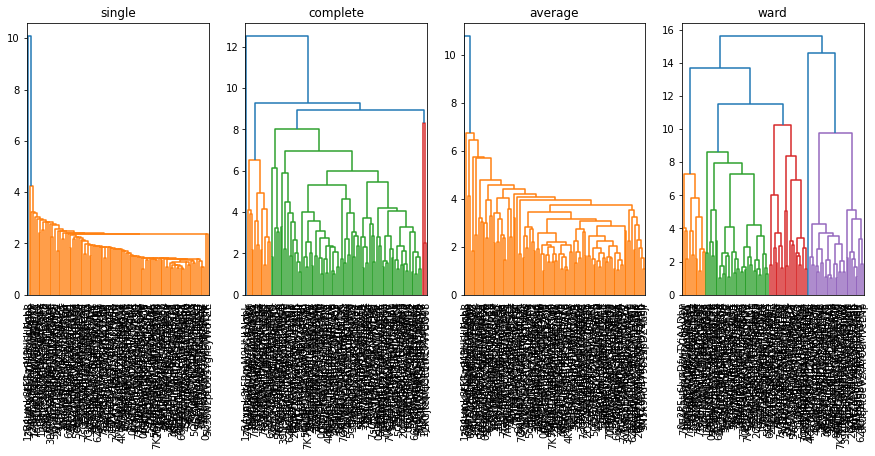

In [11]:
# hclust
METHODS = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(15,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 4, i+1)
  plt.title(m)
  dendrogram(linkage(X.values, method=m),
             labels = X.index,
             leaf_rotation=90,
             leaf_font_size=10)
  
plt.show()

In [ ]:
# average or ward look like appear to have favorable properties to me
# we can think of genres as a macro or micro level
# for example: https://www.musicgenreslist.com/
# dataset appears to be a list of top 100 songs
# I am going to use average because I want to test if the top songs span some generes


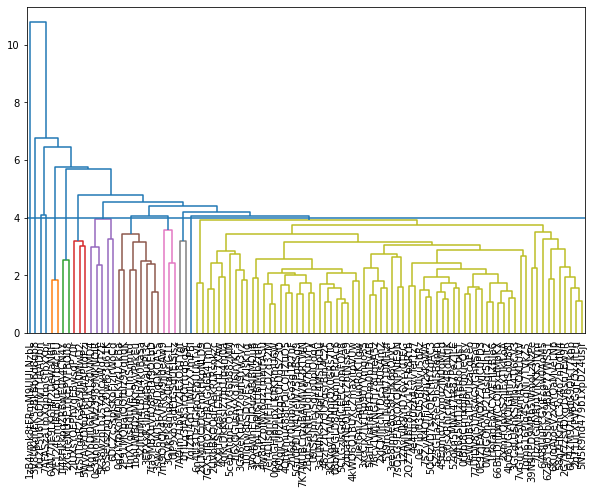

In [12]:
plt.figure(figsize=(10, 6))

avg = linkage(X.values, method="average")
dendrogram(avg,
          labels = X.index,
          leaf_rotation=90,
          leaf_font_size=10, color_threshold=4)

plt.axhline(y=4)
plt.show()

In [13]:
# the clusters
hc_labs = fcluster(avg, 4, criterion="distance")

# the metrics
hc_silo = silhouette_score(X, hc_labs)
hc_ssamps = silhouette_samples(X, hc_labs)
np.unique(hc_labs)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32)

In [14]:
# Kmeans
KS = range(2, 30)

# storage
inertia = []
silo = []

for k in KS:
  km = KMeans(k)
  km.fit(X)
  labs = km.predict(X)
  inertia.append(km.inertia_)
  silo.append(silhouette_score(X, labs))


/opt/miniconda3/envs/ba820/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/envs/ba820/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


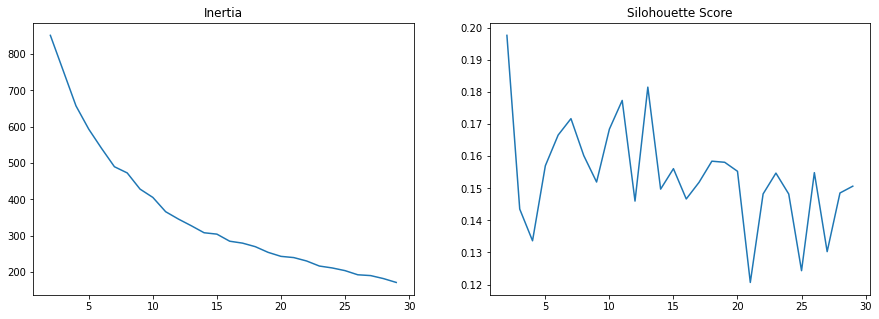

In [15]:
plt.figure(figsize=(15,5))


plt.subplot(1, 2, 1)
plt.title("Inertia")
sns.lineplot(KS, inertia)

plt.subplot(1, 2, 2)
plt.title("Silohouette Score")
sns.lineplot(KS, silo)

plt.show()

In [16]:
for i, s in enumerate(silo[:10]):
  print(i+2,s) # +2 to align num clusters with value

2 0.19768435697612513
3 0.1435304434504902
4 0.13364094936980392
5 0.15703214252048026
6 0.16659965804195567
7 0.17172321871169163
8 0.1601927366729201
9 0.1519576924539561
10 0.16844975456665126
11 0.17739707851319886


In [ ]:
# 9 looks like a good number, we get improvement in silo score and approx. 
# where the elbow could be viewed for interita



In [17]:
# get the model
k9 = KMeans(9)
k9_labs = k9.fit_predict(X)

# metrics
k9_silo = silhouette_score(X, k9_labs)
k9_ssamps = silhouette_samples(X, k9_labs)
np.unique(k9_labs)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

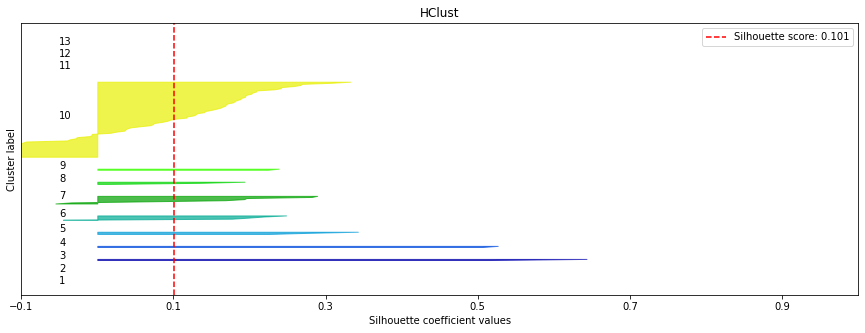

In [18]:
# lets compare via silo

skplot.metrics.plot_silhouette(X, hc_labs, title="HClust", figsize=(15,5))
plt.show()

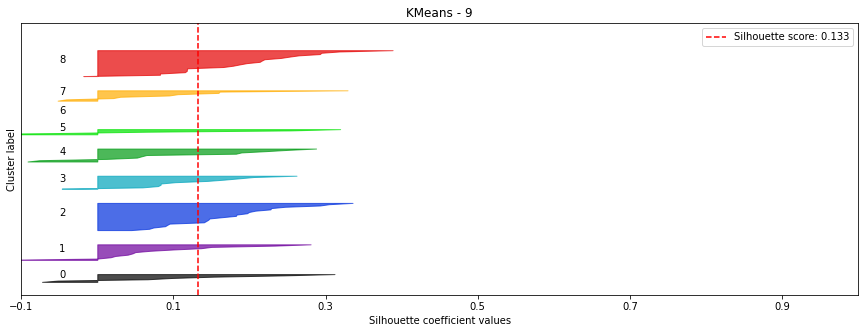

In [19]:
skplot.metrics.plot_silhouette(X, k9_labs, title="KMeans - 9", figsize=(15,5))
plt.show()

In [ ]:
# I like the Kmeans fit.  There are a few negative values, which suggests fit could be off, 
# but some of the clusters look pretty good.

In [20]:
# lets profile the songs
spotify['k9_labs'] = k9_labs

In [21]:
# profile
profile = spotify.groupby('k9_labs').mean()
profile

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
k9_labs,,,,,,,,,,,,,
0,0.470857,0.604429,4.571429,-5.617571,0.571429,0.075729,0.112861,0.000035,0.176057,0.193386,156.655571,217420.571429,3.857143
1,0.694231,0.741077,6.000000,-5.288615,0.538462,0.202015,0.139474,0.000090,0.130415,0.561769,159.802308,210895.692308,4.076923
2,0.677045,0.660227,6.090909,-5.456591,0.727273,0.068332,0.142600,0.000211,0.154086,0.361227,111.750818,213608.636364,3.954545
3,0.873273,0.553909,4.636364,-7.045455,0.727273,0.115618,0.078793,0.001224,0.108445,0.458818,121.903636,206558.818182,4.000000
4,0.674091,0.477818,7.090909,-7.730364,0.636364,0.102618,0.689636,0.000369,0.113336,0.454364,108.929091,185252.272727,3.909091
5,0.879000,0.460200,4.600000,-8.355200,0.400000,0.381200,0.176600,0.000011,0.145260,0.473400,114.010800,166924.800000,4.000000
6,0.605000,0.822000,0.000000,-4.833000,1.000000,0.043800,0.006710,0.134000,0.147000,0.288000,167.997000,187147.000000,4.000000
7,0.754778,0.701333,4.777778,-5.523556,0.666667,0.095789,0.072944,0.000025,0.434333,0.533400,107.138889,201783.000000,4.000000
8,0.743619,0.796762,4.476190,-3.847095,0.380952,0.080229,0.182419,0.000023,0.109076,0.682857,100.781905,209998.095238,4.000000


<AxesSubplot:>

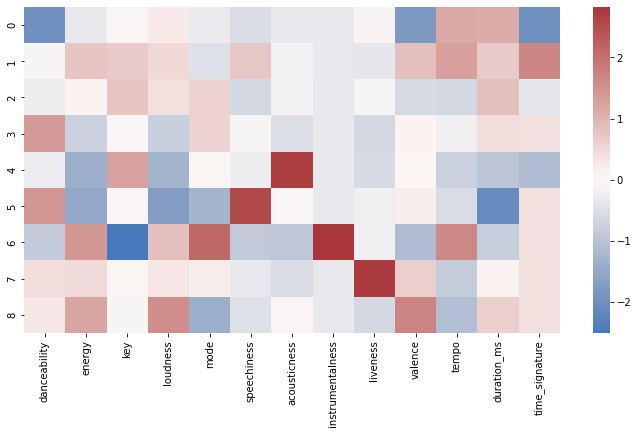

In [22]:
# heatmap
sc = StandardScaler()
profile_scaled = sc.fit_transform(profile)

plt.figure(figsize=(12, 6))
pal = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(profile_scaled, center=0, cmap=pal, xticklabels=profile.columns)

In [23]:
# counts by cluster
spotify.k9_labs.value_counts(sort=False)

5     5
7     9
3    11
8    21
4    11
1    13
0     7
2    22
6     1
Name: k9_labs, dtype: int64

In [ ]:
# OBSERVATIONS:
#1. profile 0 = apperas to be longer songs
#2. profile 1 = higher likelihood of a live song
#3. profile 5 = only 1 song, and its larger on instrumentalness
#4. profile 4 = appears to a reprsentation of "average" songs
#5. profile 8 = the largest cluster, tends to be high on positivity measure, but less on tempo

In [ ]:
# CONSIDERATIONS
# - Look at DBSCAN
# - explore both distance metrics (euclidean used) and different linkage approaches
# - I was ok with 9 clusters because this task was to think about genre proxies.  
#   In some cases, large number of clusters are not actionable for a firm because the management is too 
#   resource intensives.  Because we are trying to dervice genres, volume is not an issue
# - consider the features themselves.  Perhaps we don't need to use them all in the case some are correlated.
# - Dive deeper into profiling.  Look at the songs within the clusters to validate as best as you can.
# - Enrich the dataset by appending/annotating the true genre of each song. 
#   After clustering the data, profile by the true genres to get a sense of how the segments align.